<a href="https://colab.research.google.com/github/harshildarji/ML-Practise/blob/master/TF%202%20Tutorials/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### [Image segmentation](https://www.tensorflow.org/beta/tutorials/images/segmentation)

**Note:** If you're running this notebook on **windows**, it will throw followng error
```python
DownloadError: Failed to get url http://www.robots.ox.ac.uk/~vgg/data/pets/data\images.tar.gz. HTTP code: 404.
```
So, instead run this notebook on **Google Colab**.

In [1]:
# installing tensorflow_examples
!pip install -q git+https://github.com/tensorflow/examples.git

In [0]:
# installing tensorflow 2.0 RC with GPU support
!pip install -q tensorflow-gpu==2.0.0-rc0
# %tensorflow_version 2.x

In [0]:
from __future__ import absolute_import, print_function, division, unicode_literals

import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
print(tf.__version__)

2.0.0-rc0


In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#### Download the dataset

In [0]:
dataset, info = tfds.load('oxford_iiit_pet:3.0.0', with_info=True)

Following functions performs single augmentation and normalization. Also, originally the segmentation mask are labeled either {1, 2, 3} which this function will convert to {0, 1, 2}.

In [0]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 128.0 - 1
    input_mask -= 1
    return input_image, input_mask

In [0]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [0]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

Let'sprepare the data.

In [0]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [0]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [0]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Take a look at an image and it's corresponding mask.

In [0]:
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()

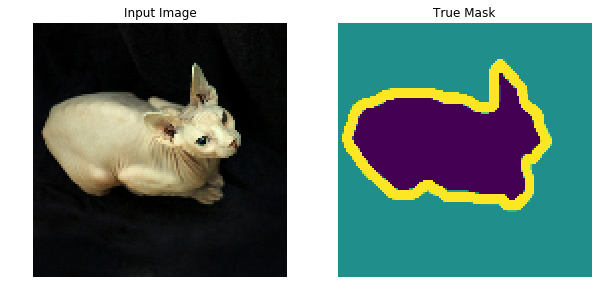

In [14]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

#### Define the model

The model used here is a modified U-Net. It consists of an encoder (downsampler) and decoder (upsampler).

In [0]:
OUTPUT_CHANNELS = 3

The encoder will be a pretrained MobileNetV2 model.

In [0]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

In [0]:
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project',
]
layers = [base_model.get_layer(name).output for name in layer_names]

In [0]:
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

In [0]:
up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),
]

In [0]:
def unet_model(output_channels):
    last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same', activation='softmax')
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs
    
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
        
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

#### Train the model

In [0]:
model = unet_model(OUTPUT_CHANNELS)

In [0]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['acc'])

Check what it predicts before training the model.

In [0]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [0]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

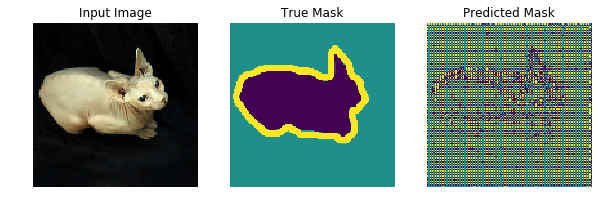

In [25]:
show_predictions()

A function to observe how model improves while it's training.

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        #clear_output(wait=None)
        show_predictions()

In [0]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VAL_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

Train for 57 steps, validate for 11 steps
Epoch 1/20


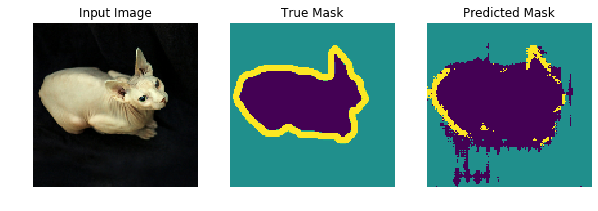

57/57 - 28s - loss: 0.5282 - acc: 0.7905 - val_loss: 0.6877 - val_acc: 0.7944
Epoch 2/20


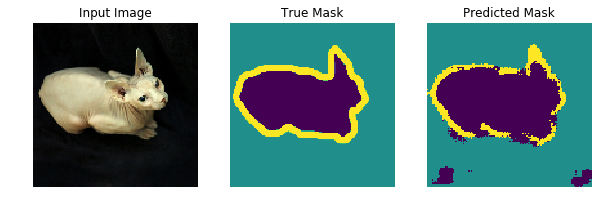

57/57 - 18s - loss: 0.3086 - acc: 0.8736 - val_loss: 0.4397 - val_acc: 0.8341
Epoch 3/20


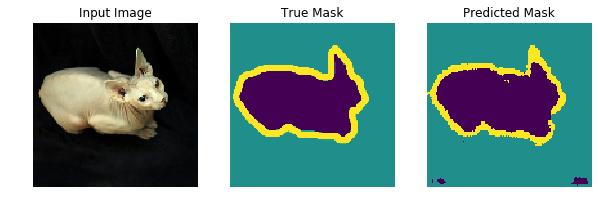

57/57 - 17s - loss: 0.2844 - acc: 0.8824 - val_loss: 0.3482 - val_acc: 0.8632
Epoch 4/20


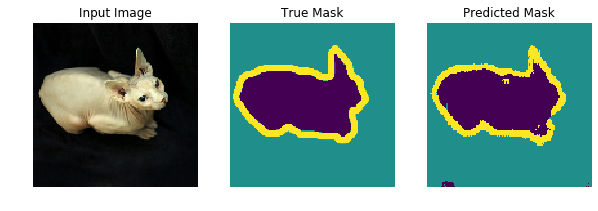

57/57 - 17s - loss: 0.2678 - acc: 0.8882 - val_loss: 0.3051 - val_acc: 0.8787
Epoch 5/20


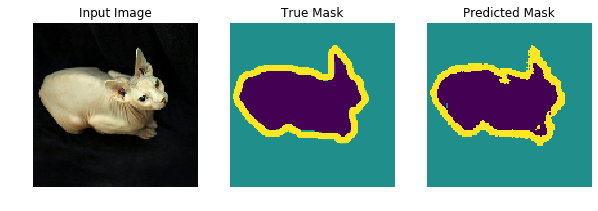

57/57 - 18s - loss: 0.2586 - acc: 0.8915 - val_loss: 0.2862 - val_acc: 0.8846
Epoch 6/20


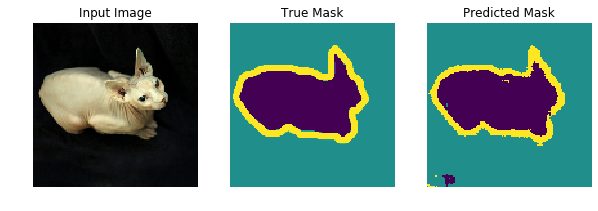

57/57 - 17s - loss: 0.2458 - acc: 0.8961 - val_loss: 0.2770 - val_acc: 0.8870
Epoch 7/20


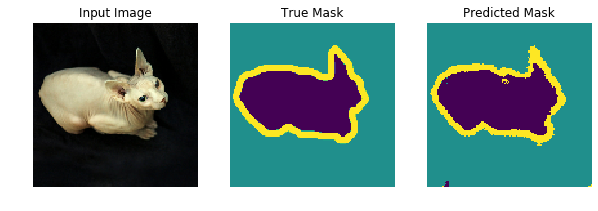

57/57 - 17s - loss: 0.2414 - acc: 0.8973 - val_loss: 0.2797 - val_acc: 0.8872
Epoch 8/20


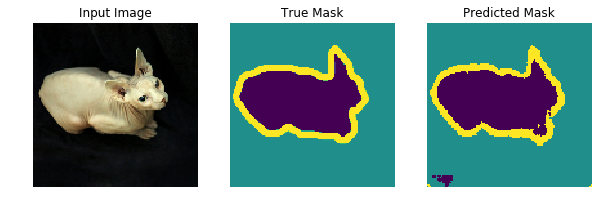

57/57 - 17s - loss: 0.2306 - acc: 0.9015 - val_loss: 0.2818 - val_acc: 0.8865
Epoch 9/20


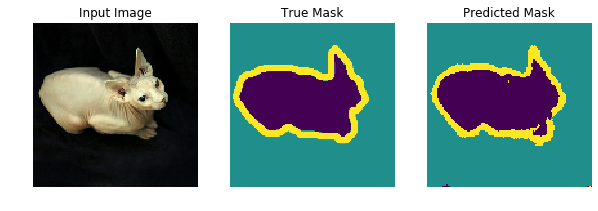

57/57 - 18s - loss: 0.2241 - acc: 0.9040 - val_loss: 0.2880 - val_acc: 0.8855
Epoch 10/20


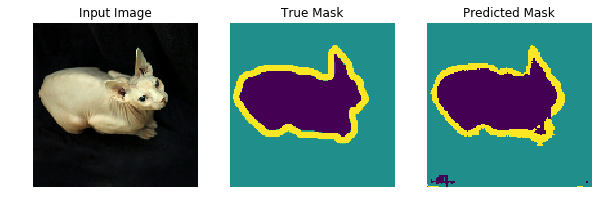

57/57 - 17s - loss: 0.2143 - acc: 0.9074 - val_loss: 0.2856 - val_acc: 0.8865
Epoch 11/20


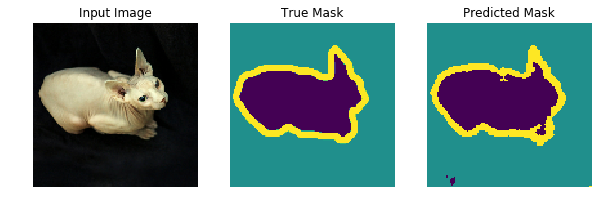

57/57 - 17s - loss: 0.2110 - acc: 0.9083 - val_loss: 0.2835 - val_acc: 0.8869
Epoch 12/20


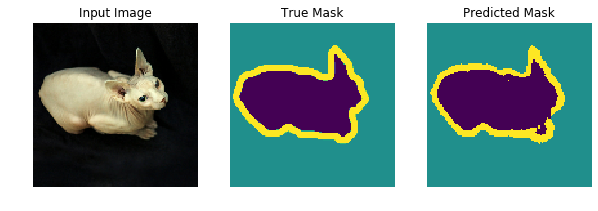

57/57 - 17s - loss: 0.2002 - acc: 0.9126 - val_loss: 0.2856 - val_acc: 0.8878
Epoch 13/20


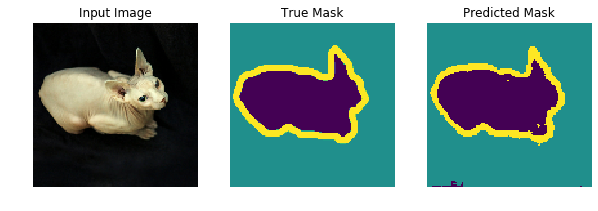

57/57 - 18s - loss: 0.1926 - acc: 0.9155 - val_loss: 0.2894 - val_acc: 0.8883
Epoch 14/20


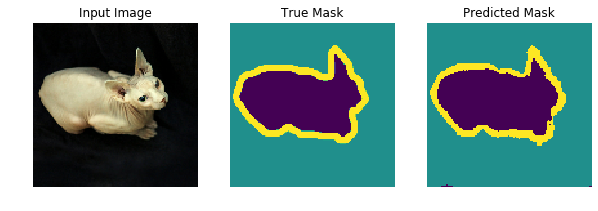

57/57 - 17s - loss: 0.1880 - acc: 0.9170 - val_loss: 0.3122 - val_acc: 0.8838
Epoch 15/20


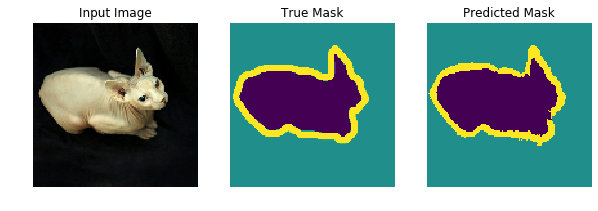

57/57 - 17s - loss: 0.1815 - acc: 0.9198 - val_loss: 0.3005 - val_acc: 0.8847
Epoch 16/20


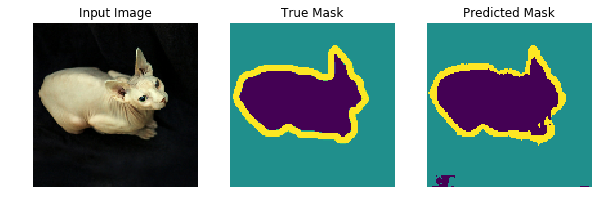

57/57 - 17s - loss: 0.1726 - acc: 0.9231 - val_loss: 0.3333 - val_acc: 0.8787
Epoch 17/20


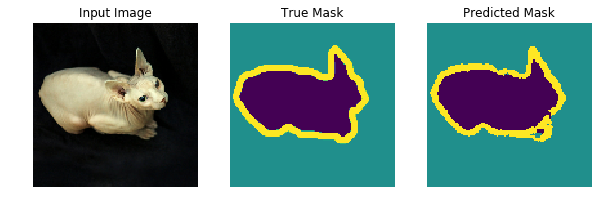

57/57 - 17s - loss: 0.1654 - acc: 0.9261 - val_loss: 0.3037 - val_acc: 0.8833
Epoch 18/20


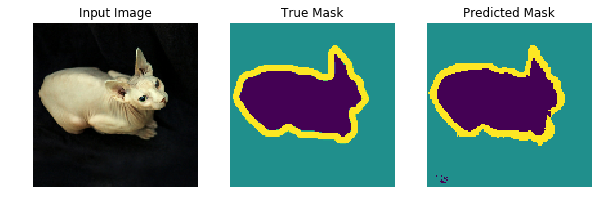

57/57 - 17s - loss: 0.1612 - acc: 0.9277 - val_loss: 0.3137 - val_acc: 0.8849
Epoch 19/20


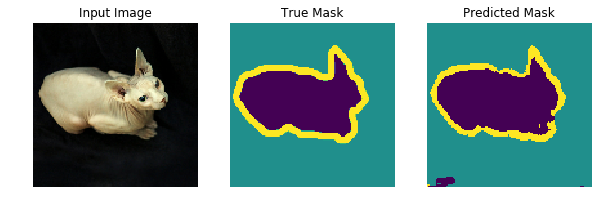

57/57 - 17s - loss: 0.1518 - acc: 0.9315 - val_loss: 0.3533 - val_acc: 0.8829
Epoch 20/20


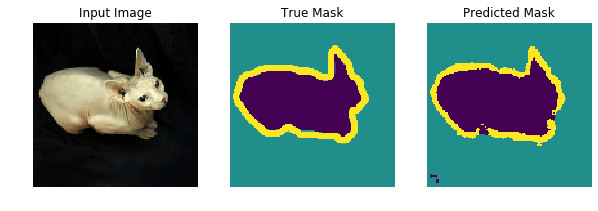

57/57 - 17s - loss: 0.1484 - acc: 0.9328 - val_loss: 0.3592 - val_acc: 0.8772


In [28]:
history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VAL_STEPS, validation_data=test_dataset, verbose=2, callbacks=[DisplayCallback()])

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

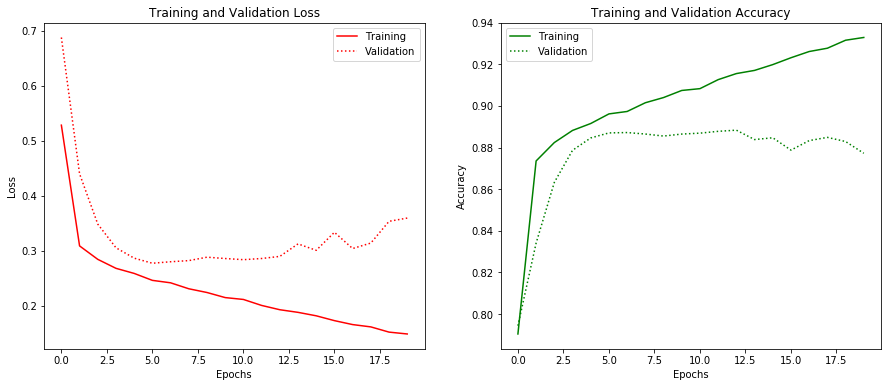

In [30]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, 'r', label='Training')
plt.plot(range(EPOCHS), val_loss, 'r:', label='Validation')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), acc, 'g', label='Training')
plt.plot(range(EPOCHS), val_acc, 'g:', label='Validation')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

#### Make predictions

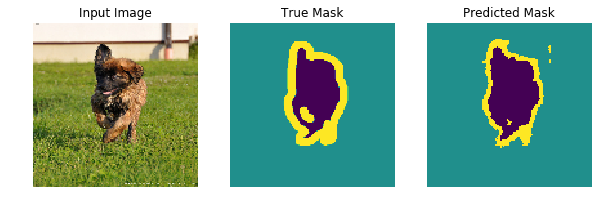

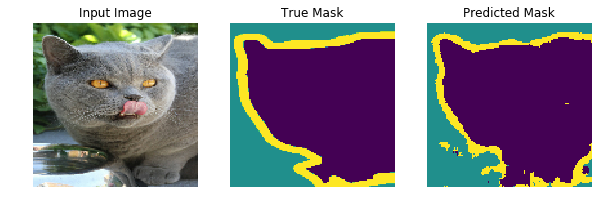

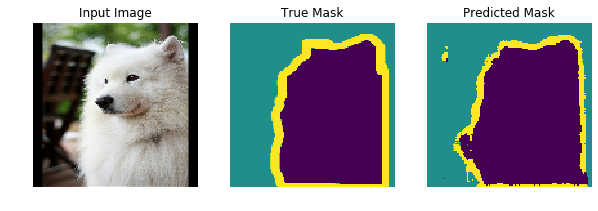

In [31]:
show_predictions(test_dataset, 3)